In [182]:
import yaml
import pandas as pd
import time
import joblib
from backend.utils.data_preprocessor import DataPreprocessor
from sklearn.preprocessing import MinMaxScaler

with open('../config.yaml', 'r') as config_file:
    config = yaml.safe_load(config_file)

interval: str = "1h"

training_file_path: str = "../data/twelvedata/combined.csv"
validation_file_path: str = f"../data/twelvedata/feature time series ({interval})/MSFT_feature_time_series.csv"

start_time = time.time()
pd.set_option('display.max_columns', None)

training_df = pd.read_csv(training_file_path)
validation_df = pd.read_csv(validation_file_path)

In [183]:
lookback_period: int = config['preprocess']['lookback_period']
target: str = config['preprocess']['target']
trend_length: int = config['preprocess']['trend_length']
training_preprocessor = DataPreprocessor(time_series=training_df, lookback_period=lookback_period, target=target, trend_length=trend_length)
validation_preprocessor = DataPreprocessor(time_series=validation_df, lookback_period=lookback_period, target=target, trend_length=trend_length)

X_train = training_preprocessor.feature_data_batched
y_train = training_preprocessor.label_data

X_val = validation_preprocessor.feature_data_batched
y_val = validation_preprocessor.label_data


In [184]:
X_train = X_train[:-training_preprocessor.trend_length]
y_train = y_train[:-training_preprocessor.trend_length]

X_val = X_val[:-validation_preprocessor.trend_length]
y_val = y_val[:-validation_preprocessor.trend_length]

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])

end_time = time.time()
loading_time = end_time - start_time

print("Loading time: ", loading_time)
print("Training Dataset shape:", training_df.shape)
print("Validation Dataset shape:", validation_df.shape)
print("Training sets shape:", X_train.shape, y_train.shape)
print("Validation sets shape:", X_val.shape, y_val.shape)


Loading time:  28.031976222991943
Training Dataset shape: (104370, 51)
Validation Dataset shape: (4970, 51)
Training sets shape: (104365, 3, 53) (104365,)
Validation sets shape: (4965, 3, 53) (4965,)


In [185]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler_filename: str = "scaler.save"
X_train_scaled_reshaped = scaler.fit_transform(X_train_reshaped)
X_val_scaled_reshaped = scaler.transform(X_val_reshaped)

joblib.dump(scaler, scaler_filename)

X_train_scaled = X_train_scaled_reshaped.reshape(X_train.shape)
X_val_scaled = X_val_scaled_reshaped.reshape(X_val.shape)

In [186]:
from backend.models.stock_trend_lstm_model import StockTrendLSTMModel

input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
epochs: int = config["model"]["epochs"]
batch_size: int = config["model"]["batch_size"]
my_model = StockTrendLSTMModel(input_shape, X_train_scaled, y_train, X_val_scaled, y_val, epochs, batch_size)
history = my_model.train()

Total number of weights in the model: 1761
Epoch 1/75
408/408 [==============================] - 11s 12ms/step - loss: 0.5744 - accuracy: 0.7081 - val_loss: 0.4877 - val_accuracy: 0.7724
Epoch 2/75
408/408 [==============================] - 3s 8ms/step - loss: 0.4470 - accuracy: 0.8064 - val_loss: 0.4293 - val_accuracy: 0.8177
Epoch 3/75
408/408 [==============================] - 3s 8ms/step - loss: 0.4235 - accuracy: 0.8226 - val_loss: 0.4230 - val_accuracy: 0.8197
Epoch 4/75
408/408 [==============================] - 3s 8ms/step - loss: 0.4183 - accuracy: 0.8251 - val_loss: 0.4200 - val_accuracy: 0.8205
Epoch 5/75
408/408 [==============================] - 3s 8ms/step - loss: 0.4144 - accuracy: 0.8259 - val_loss: 0.4169 - val_accuracy: 0.8220
Epoch 6/75
408/408 [==============================] - 3s 8ms/step - loss: 0.4111 - accuracy: 0.8265 - val_loss: 0.4139 - val_accuracy: 0.8220
Epoch 7/75
408/408 [==============================] - 3s 8ms/step - loss: 0.4093 - accuracy: 0.8264 - v

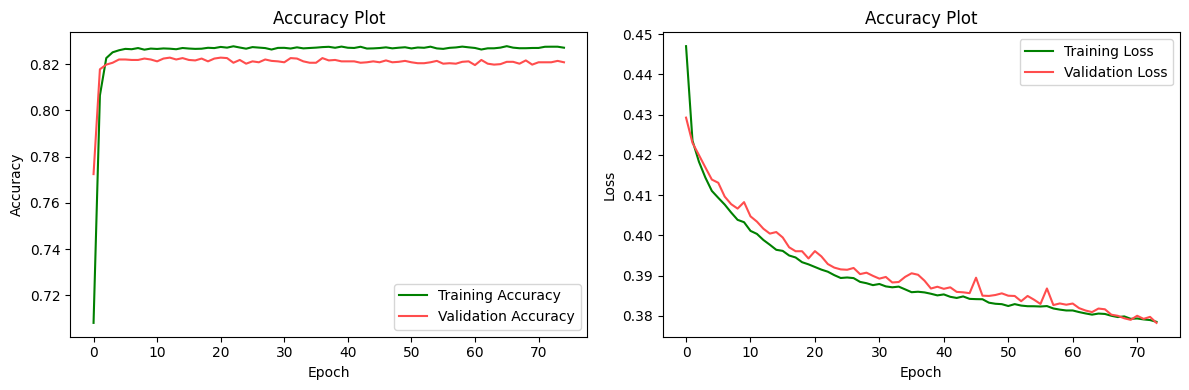

In [187]:
from backend.utils.visualizing_service import plot_model_accuracy
plot_model_accuracy(history)